In [3]:
from numpy import *
row,col=747,1000
fx = 2555*col/2592
print 'fx=',fx
fy = 2586*row/1936
print 'fy=',fy
K = diag([fx,fy,1]) #tao ma tran co duong cheo la cac gia tri trong ds truyen vao, cac gia tri # = 0
print 'K=',K
K[0,2] = 0.5*col
K[1,2] = 0.5*row
print K

fx= 985
fy= 997
K= [[985   0   0]
 [  0 997   0]
 [  0   0   1]]
[[985   0 500]
 [  0 997 373]
 [  0   0   1]]


processed tmp.pgm to im0.sift
processed tmp.pgm to im1.sift
[ -1.41256812e+03  -2.06390173e+02  -1.11214808e+00]
[  1.27012593e+03   1.85577961e+02   1.00000000e+00]


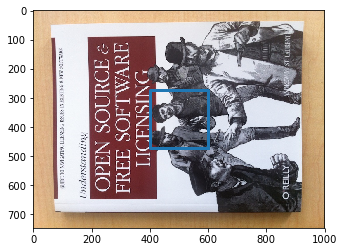

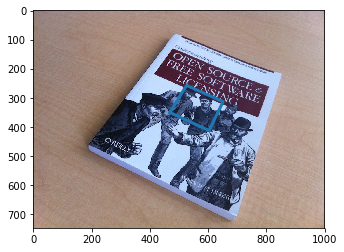

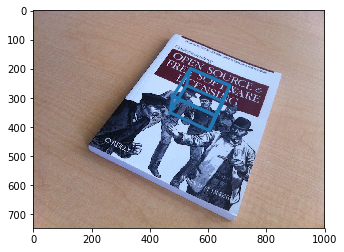

"with open('ar_camera.pkl','w') as f:\n    pickle.dump(K,f)\n    pickle.dump(dot(linalg.inv(K),cam2.P),f)"

In [3]:
import homography
import camera
import sift
from numpy import *
from PIL import Image
from pylab import *
import pickle

# compute features
sift.process_image('book_frontal.JPG','im0.sift')
l0,d0 = sift.read_features_from_file('im0.sift')
sift.process_image('book_perspective.JPG','im1.sift')
l1,d1 = sift.read_features_from_file('im1.sift')

# match features and estimate homography
matches = sift.match_twosided(d0,d1)
ndx = matches.nonzero()[0]
fp = homography.make_homog(l0[ndx,:2].T)
ndx2 = [int(matches[i]) for i in ndx]
tp = homography.make_homog(l1[ndx2,:2].T)
model = homography.RansacModel()
H = homography.H_from_ransac(fp,tp,model)

def cube_points(c,wid):
    """ Creates a list of points for plotting
    a cube with plot. (the first 5 points are
    the bottom square, some sides repeated). """
    p = []
    #bottom
    p.append([c[0]-wid,c[1]-wid,c[2]-wid])
    p.append([c[0]-wid,c[1]+wid,c[2]-wid])
    p.append([c[0]+wid,c[1]+wid,c[2]-wid])
    p.append([c[0]+wid,c[1]-wid,c[2]-wid])
    p.append([c[0]-wid,c[1]-wid,c[2]-wid]) #same as first to close plot
    #top
    p.append([c[0]-wid,c[1]-wid,c[2]+wid])
    p.append([c[0]-wid,c[1]+wid,c[2]+wid])
    p.append([c[0]+wid,c[1]+wid,c[2]+wid])
    p.append([c[0]+wid,c[1]-wid,c[2]+wid])
    p.append([c[0]-wid,c[1]-wid,c[2]+wid]) #same as first to close plot
    #vertical sides
    p.append([c[0]-wid,c[1]-wid,c[2]+wid])
    p.append([c[0]-wid,c[1]+wid,c[2]+wid])
    p.append([c[0]-wid,c[1]+wid,c[2]-wid])
    p.append([c[0]+wid,c[1]+wid,c[2]-wid])
    p.append([c[0]+wid,c[1]+wid,c[2]+wid])
    p.append([c[0]+wid,c[1]-wid,c[2]+wid])
    p.append([c[0]+wid,c[1]-wid,c[2]-wid])
    return array(p).T

def my_calibration(sz):
    row,col = sz
    fx = 2555*col/2592
    fy = 2586*row/1936
    K = diag([fx,fy,1])
    K[0,2] = 0.5*col
    K[1,2] = 0.5*row
    return K

# camera calibration
K = my_calibration((747,1000))

# 3D points at plane z=0 with sides of length 0.2
box = cube_points([0,0,0.1],0.1)


# project bottom square in first image
cam1 = camera.Camera( hstack((K,dot(K,array([[0],[0],[-1]])) )) )

# first points are the bottom square
box_cam1 = cam1.project(homography.make_homog(box[:,:5]))

# use H to transfer points to the second image
box_trans = homography.normalize(dot(H[0],box_cam1))

# compute second camera matrix from cam1 and H
cam2 = camera.Camera(dot(H[0],cam1.P))
A = dot(linalg.inv(K),cam2.P[:,:3])
A = array([A[:,0],A[:,1],cross(A[:,0],A[:,1])]).T
cam2.P[:,:3] = dot(K,A)
# project with the second camera
box_cam2 = cam2.project(homography.make_homog(box))
# test: projecting point on z=0 should give the same
point = array([1,1,0,1]).T
print homography.normalize(dot(dot(H[0],cam1.P),point))
print cam2.project(point)

im0 = array(Image.open('book_frontal.JPG'))
im1 = array(Image.open('book_perspective.JPG'))
# 2D projection of bottom square
figure()
imshow(im0)
plot(box_cam1[0,:],box_cam1[1,:],linewidth=3)
# 2D projection transferred with H
figure()
imshow(im1)
plot(box_trans[0,:],box_trans[1,:],linewidth=3)
# 3D cube
figure()
imshow(im1)
plot(box_cam2[0,:],box_cam2[1,:],linewidth=3)
show()

'''with open('ar_camera.pkl','w') as f:
    pickle.dump(K,f)
    pickle.dump(dot(linalg.inv(K),cam2.P),f)'''